In [16]:
import tweepy
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import time
import datetime
from collections import Counter

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

consumer_key = "Kw6QdU3K6aevWMo7cmOxzThLD"
consumer_secret = "dyMMRVQaDsvJZoBrZGdy1zlk1tHGlgcjijFNhT13oKc3GqJFPy"
access_token = "75068443-RZcsP8ypDdOiQWrQyqiMLic7cgvknrlO6DG5FqAry"
access_token_secret = "Loky5gOKJ3EpYPoYXdDkuOI2BpMKnp7N9cJPq7F1Yxp11"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [17]:
public_tweets = api.search(target, count=100, result_type="recent")

## Search 1500 Tweets on Quickboos and its Competitors

In [18]:
# Target Search Term
target_terms = ("@QuickBooks", "@ZohoBooks", "@Xero")

# "Real Person" Filters
min_tweets = 5
max_tweets = 10000
max_followers = 2500
max_following = 2500
lang = "en"

# Array to hold sentiment
sentiments = []

# Loop through all target users
for target in target_terms:
    
    # Defining a counter
    counter = 1

    # Loop through 15 times
    for x in range(15):

        # Run search around each tweet
        public_tweets = api.search(target, count=100, result_type="recent")

        # Loop through all tweets
        for tweet in public_tweets["statuses"]:
            
            # Use filters to check if user meets conditions
            if (tweet["user"]["followers_count"] < max_followers and
                    tweet["user"]["statuses_count"] > min_tweets and
                    tweet["user"]["statuses_count"] < max_tweets and
                    tweet["user"]["friends_count"] < max_following and
                    tweet["user"]["lang"] == lang):

                # Run Vader Analysis on each tweet
                compound = analyzer.polarity_scores(tweet["text"])["compound"]
                pos = analyzer.polarity_scores(tweet["text"])["pos"]
                neu = analyzer.polarity_scores(tweet["text"])["neu"]
                neg = analyzer.polarity_scores(tweet["text"])["neg"]
                tweets_ago = counter
                
                # Conversion of actual timestamp
                raw_time = tweet["created_at"]
                converted_time = datetime.datetime.strptime(raw_time, "%a %b %d %H:%M:%S %z %Y")
                time_format = converted_time.strftime("%Y-%m-%d")
                
                # Store all the sentiments
                try:
                    sentiments.append({"Source Account": tweet['entities']['user_mentions'][0]['name'],
                                       "Products": target,
                                       "Actual Date": tweet["created_at"],
                                       "Date": time_format,
                                       "Tweet Polarity": compound,
                                       "Positive": pos,
                                       "Neutral": neu,
                                       "Negative": neg,
                                       "Tweets Ago": counter})
                except:
                    continue

                # Add to counter 
                counter = counter + 1

## Calculate the Sentiment Average

In [19]:
sentiments_pd = pd.DataFrame(sentiments)
sentiments_pd.head()

,Actual Date,Date,Negative,Neutral,Positive,Products,Source Account,Tweet Polarity,Tweets Ago
0,Thu Jan 18 06:00:49 +0000 2018,2018-01-18,0.0,0.441,0.559,@QuickBooks,Hubdoc,0.5859,1
1,Thu Jan 18 04:43:47 +0000 2018,2018-01-18,0.0,1.000,0.000,@QuickBooks,Arshaad Mohamed,0.0000,2
2,Thu Jan 18 04:34:39 +0000 2018,2018-01-18,0.0,1.000,0.000,@QuickBooks,Amjad,0.0000,3
3,Thu Jan 18 04:31:18 +0000 2018,2018-01-18,0.0,0.610,0.390,@QuickBooks,Arshaad Mohamed,0.4926,4
4,Thu Jan 18 04:03:13 +0000 2018,2018-01-18,0.0,0.744,0.256,@QuickBooks,Intuit QuickBooks,0.6705,5


In [20]:
sentiments_groupby = sentiments_pd.groupby(['Products'])
sentiments_mean = sentiments_groupby['Tweet Polarity'].mean()
sentiments_final = pd.DataFrame(sentiments_mean).reset_index()
sentiments_final.head()

,Products,Tweet Polarity
0,@QuickBooks,0.294070
1,@Xero,0.229171
2,@ZohoBooks,0.149786


In [21]:
# Output a csv file for analyze
sentiments_pd.to_csv("quickbook_competitors_tweet_data.csv")

## Visualize Sentiments on Bar and Scatter Plot

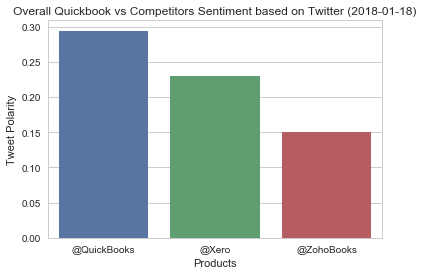

In [22]:
import seaborn as sns

sns.set(style='whitegrid', color_codes=True)
# tips = sns.load_dataset(sentiment_avg_pd)
# sns.barplot(x='Products', y = 'Compound', data = tips)

sns.barplot(x=sentiments_final['Products'], y = sentiments_final['Tweet Polarity'] , 
            )
plt.title("Overall Quickbook vs Competitors Sentiment based on Twitter (%s)" %datetime.date.today())

plt.show()

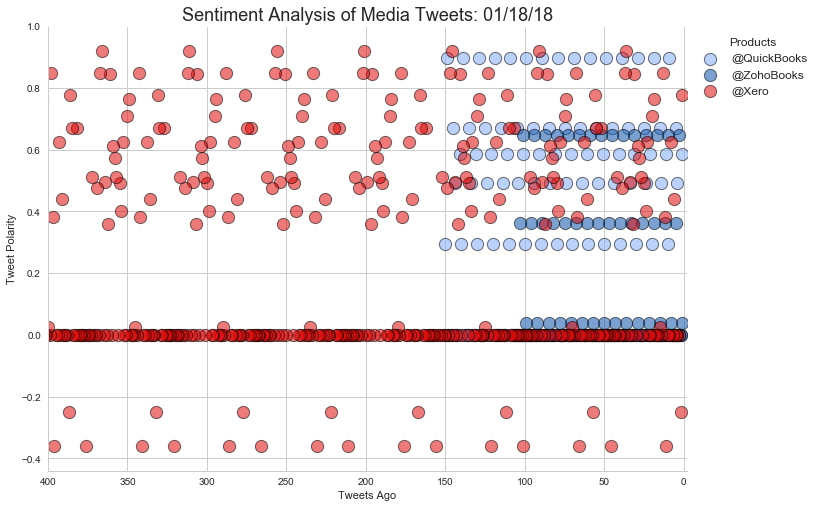

In [25]:
#create lmplot using seasborn

#set colorlist for charts
clrlist = ["#82acf9", "#0f55aa", "#e00b0b"]
#clrlist = ["#82acf9", "#e00b0b"]

#sns.set_palette(clrlist)
sns.color_palette(clrlist)

#create chart
MediaTweetAnalysis = sns.lmplot(x="Tweets Ago", y="Tweet Polarity", data=sentiments_pd, 
           hue="Products", size=7, aspect=1.4,
           legend_out=False, legend=True, 
           scatter_kws={"s":150, 'alpha':.55, 'edgecolors':"black", 'linewidth':1}, 
                                fit_reg=False, palette=clrlist)
plt.xlim(400,-2)
plt.title("Sentiment Analysis of Media Tweets: %s" % time.strftime('%x'), fontsize=18)
plt.legend(bbox_to_anchor=(1, 1), ncol=1, title="Products", fontsize=12)
plt.show(MediaTweetAnalysis)

## Delete

In [65]:
a = sentiments_pd.set_index('Source Account')
a = a.loc[['Wave HQ', 'Intuit QuickBooks', 'Xero accounting app', 'Zoho', 'Intuit']]
a = a.reset_index()
a.head()
Counter(a['Source Account'])

Counter({'Intuit': 15,
         'Intuit QuickBooks': 555,
         'Wave HQ': 465,
         'Xero accounting app': 510,
         'Zoho': 30})